<a href="https://colab.research.google.com/github/jeromeslash83/Data-Science/blob/main/Rookie_Ranking_NBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2022-23 Season NBA Rookies Ranking Practice**

**This project is a practice project aiming to rank the top 4 rookies of this season using data analytics. My goal here is to see who is leading the ROTY Race and practice visualizations for NBA Analysis. I will be ranking Chet Holmgren, Victor Wembanyama, Ausar Thompson and Dereck Lively II in this practice. I have hidden the codes for this notebook so that it is not daunting to read for a lot of people. If you're interested in how its done, pls feel free to message me or check my GitHub Repositories [here](https://github.com/jeromeslash83).

Let's start.

# **Preparations**

Here I will be installing and importing a lot of the dependencies of the project like 'pandas', 'seaborn', 'matplotlib', 'sci-kit learn' and the 'nba_api'.

Also, I created here my pre-drawn nba court for shot visualization.

In [216]:
# @title
!pip install nba_api

In [217]:
# @title
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog, shotchartdetail
from nba_api.stats.endpoints import playergamelog, leaguedashplayerstats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from urllib.request import urlopen
from sklearn.preprocessing import StandardScaler

In [218]:
# @title
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2):
    if ax is None:
        ax = plt.gca()

    # Fill in the court
    court_color = '#ffdfba'  # A light brown color that can represent hardwood
    ax.add_patch(Rectangle((-250, -47.5), 500, 470, facecolor=court_color, zorder=0))

    # The hoop
    hoop = Circle((0,-15.5), radius=7.5, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-30, -25.5), 60, 0.4, linewidth=lw, color=color)

    # The paint
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False)

    # Free Throw Top Arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color, linestyle='dashed')


    # Three point line
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0, linewidth=lw, color=color)

    # List of elements to draw on the court
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw, corner_three_a, corner_three_b, three_arc, center_outer_arc, center_inner_arc]

    for element in court_elements:
        ax.add_patch(element)

    # Set the limits for the court in the x and y axis
    ax.set_xlim(-250, 250)
    ax.set_ylim(422.5, -35.5)

    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Set an aspect ratio that ensures the court is drawn proportionally
    ax.set_aspect('equal')

    return ax

# **Loading the datasets, data manipulation and feature engineering using APIs.**

The data for the 4 rookies were scraped using the nba_api processed, cleaned and feature engineered for the analysis in the next steps.

The added features were considered since I was not able to get the proper  and here are the following explanations on how it was computed.

###1. **Simplified PER (Player Efficiency Rating):**

> #### **Formula: simplified_PER = (PTS * 0.5) + (AST * 0.35) + (REB * 0.3) + (STL * 0.25) + (BLK * 0.25) - ((FGA - FGM) * 0.5) - ((FTA - FTM) * 0.75) - (TOV * 0.5)**

> This formula combines several statistical contributions (points, assists, rebounds, steals, and blocks), each multiplied by a specific weight. It also subtracts for missed shots and turnovers. The weights (like 0.5 for points, 0.35 for assists) are arbitrary and designed to balance the value of different contributions.


###2. **Approximate OWS (Offensive Win Shares):**

> ##### **Formula: approx_OWS = PTS / 10**

> This is a simple estimation that assigns one offensive win share for every 10 points scored. It's a basic way to link a player's scoring to their team's offensive success.

###3. **Approximate DWS (Defensive Win Shares):**

> #### **Formula: approx_DWS = (STL + BLK) / 5**

> This formula estimates defensive contribution by adding steals and blocks, two key defensive actions, and dividing by 5. It's a basic method to quantify defensive impact.

###4. **Approximate WS (Win Shares):**

> #### **Formula: approx_WS = approx_OWS + approx_DWS**
> This adds the approximate offensive and defensive win shares to get a general idea of the total impact a player has on winning games.

In [248]:
# @title
player_names = ["Chet Holmgren", "Victor Wembanyama", "Ausar Thompson", "Dereck Lively II"]
all_players = players.get_players()

# Create a dictionary to store player IDs
player_ids = {name: [player for player in all_players if player['full_name'] == name][0]['id'] for name in player_names}

season = '2023-24'

# Create a dictionary to store each player's shot data DataFrame
player_shot_data_dict = {}

for name, player_id in player_ids.items():
    shot_chart = shotchartdetail.ShotChartDetail(team_id=0, player_id=player_id, season_nullable=season, context_measure_simple='FGA')
    player_shot_data_dict[name] = shot_chart.get_data_frames()[0]
    player_shot_data_dict[name]['Player'] = name

In [249]:
# @title
Wemby = player_shot_data_dict['Victor Wembanyama']
Chet = player_shot_data_dict['Chet Holmgren']
Ausar = player_shot_data_dict['Ausar Thompson']
Lively = player_shot_data_dict['Dereck Lively II']

In [250]:
# @title
season_stats = {}
for name, player_id in player_ids.items():
    stats = playergamelog.PlayerGameLog(player_id=player_id, season='2023-24').get_data_frames()[0]
    season_stats[name] = stats

all_players_adv_stats = leaguedashplayerstats.LeagueDashPlayerStats(season='2023-24', measure_type_detailed_defense='Advanced', per_mode_detailed='PerGame').get_data_frames()[0]

advanced_metrics = {}
for name, player_id in player_ids.items():
    player_adv_stats = all_players_adv_stats[all_players_adv_stats['PLAYER_ID'] == player_id]
    advanced_metrics[name] = player_adv_stats

In [251]:
# @title
season_stats_total = season_stats.copy()
combined_data_total = []
for player in season_stats.keys():
    season_stats_total[player]['Player'] = player
    season_stats_total[player] = season_stats[player].groupby(['Player_ID', 'Player', 'SEASON_ID']).agg({
    'Game_ID': 'count',
    'MIN': 'sum',
    'FGM': 'sum',
    'FGA': 'sum',
    'FG_PCT': 'mean',
    'FG3M': 'sum',
    'FG3A': 'sum',
    'FG3_PCT': 'mean',
    'FTM': 'sum',
    'FTA': 'sum',
    'FT_PCT': 'mean',
    'OREB': 'sum',
    'DREB': 'sum',
    'REB': 'sum',
    'AST': 'sum',
    'STL': 'sum',
    'BLK': 'sum',
    'TOV': 'sum',
    'PF': 'sum',
    'PTS': 'sum',
    'PLUS_MINUS': 'mean',
    'VIDEO_AVAILABLE': 'sum'
})
    season_stats_total[player].reset_index(inplace=True)
    combined_data_total.append(season_stats_total[player])

combined_total = pd.concat(combined_data_total, ignore_index=True)

In [252]:
# @title
season_stats_per_game = season_stats.copy()
combined_data_pg = []
for player in season_stats.keys():
    season_stats_per_game[player]['Player'] = player
    season_stats_per_game[player] = season_stats_per_game[player].groupby(['Player_ID', 'Player', 'SEASON_ID']).agg({
        'Game_ID': 'count',
        'MIN': 'mean',
        'FGM': 'mean',
        'FGA': 'mean',
        'FG_PCT': 'mean',
        'FG3M': 'mean',
        'FG3A': 'mean',
        'FG3_PCT': 'mean',
        'FTM': 'mean',
        'FTA': 'mean',
        'FT_PCT': 'mean',
        'REB': 'mean',
        'OREB': 'mean',
        'DREB': 'mean',
        'AST': 'mean',
        'STL': 'mean',
        'BLK': 'mean',
        'TOV': 'mean',
        'PF': 'mean',
        'PTS': 'mean',
        'PLUS_MINUS': 'mean',
        'VIDEO_AVAILABLE': 'first'
    })

    season_stats_per_game[player].reset_index(inplace=True)

In [253]:
# @title
for player in season_stats_per_game.keys():
    season_stats_per_game[player]['simplified_PER'] = (season_stats_per_game[player]['PTS'] * 0.5
                        + season_stats_per_game[player]['AST'] * 0.35
                        + season_stats_per_game[player]['REB'] * 0.3
                        + season_stats_per_game[player]['STL'] * 0.25
                        + season_stats_per_game[player]['BLK'] * 0.25
                        - (season_stats_per_game[player]['FGA'] - season_stats_per_game[player]['FGM']) * 0.5
                        - (season_stats_per_game[player]['FTA'] - season_stats_per_game[player]['FTM']) * 0.75
                        - season_stats_per_game[player]['TOV'] * 0.5)
    season_stats_per_game[player]['approx_OWS'] = season_stats_per_game[player]['PTS'] / 10
    season_stats_per_game[player]['approx_DWS'] = (season_stats_per_game[player]['STL'] + season_stats_per_game[player] ['BLK']) / 5
    season_stats_per_game[player]['approx_WS'] = season_stats_per_game[player]['approx_OWS'] + season_stats_per_game[player] ['approx_DWS']
    season_stats_per_game[player] = pd.merge(season_stats_per_game[player], advanced_metrics[player], left_on=['Player_ID','Player'], right_on=['PLAYER_ID', 'PLAYER_NAME'], how='inner')
    season_stats_per_game[player] = season_stats_per_game[player][['Player', 'Player_ID', 'SEASON_ID', 'PTS', 'AST', 'REB', 'STL', 'BLK', 'TS_PCT',
                                                                   'AST_PCT', 'REB_PCT', 'PLUS_MINUS', 'simplified_PER', 'approx_OWS','approx_DWS', 'approx_WS']]
    combined_data_pg.append(season_stats_per_game[player])

combined_pg = pd.concat(combined_data_pg, ignore_index=True)

data =   {'Image_URL': ['https://cdn.nba.com/headshots/nba/latest/1040x760/1631096.png', 'https://cdn.nba.com/headshots/nba/latest/1040x760/1641705.png', 'https://cdn.nba.com/headshots/nba/latest/1040x760/1641709.png', 'https://cdn.nba.com/headshots/nba/latest/1040x760/1641726.png']}
data = pd.Series(data['Image_URL'], name='Image_URL')


# **Finalized datasets**

Here are the cleaned and finalized dataset of the 4 Rookies that we will rank.

In [254]:
# @title
combined_total

,Player_ID,Player,SEASON_ID,Game_ID,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,1631096,Chet Holmgren,22023,14,415,83,147,0.590643,23,50,0.507143,49,54,0.829071,21,88,109,36,13,30,30,40,238,5.071429,14
1,1641705,Victor Wembanyama,22023,14,416,98,231,0.416857,21,78,0.239500,43,55,0.641000,28,99,127,35,14,36,51,37,260,-7.714286,13
2,1641709,Ausar Thompson,22023,15,457,68,155,0.433933,4,29,0.094467,30,43,0.476933,56,95,151,48,17,26,36,55,170,-7.066667,15
3,1641726,Dereck Lively II,22023,13,318,49,69,0.693846,0,2,0.000000,14,22,0.416692,38,59,97,15,8,15,14,46,112,3.461538,13


In [226]:
# @title
# Getting the proper columns only
combined_pg

,Player,Player_ID,SEASON_ID,PTS,AST,REB,STL,BLK,TS_PCT,AST_PCT,REB_PCT,PLUS_MINUS,simplified_PER,approx_OWS,approx_DWS,approx_WS
0,Chet Holmgren,1631096,22023,17.000000,2.571429,7.785714,0.928571,2.142857,0.697,0.122,0.125,5.071429,8.878571,1.700000,0.614286,2.314286
1,Victor Wembanyama,1641705,22023,18.571429,2.500000,9.071429,1.000000,2.571429,0.517,0.128,0.153,-7.714286,6.560714,1.857143,0.714286,2.571429
2,Ausar Thompson,1641709,22023,11.333333,3.200000,10.066667,1.133333,1.733333,0.489,0.153,0.157,-7.066667,5.773333,1.133333,0.573333,1.706667
3,Dereck Lively II,1641726,22023,8.615385,1.153846,7.461538,0.615385,1.153846,0.712,0.058,0.147,3.461538,5.623077,0.861538,0.353846,1.215385


# **Visualization of the Data**

### Now, we'll move on to the visualization of the data I chose shot chart and bar graphs for these. I chose the basic shot chart and the hex shot chart to see what kind on shots each rookie makes in the past 13-14 games.

In [227]:
# @title
player_shot_data = {
    'Victor Wembanyama': Wemby,
    'Chet Holmgren': Chet,
    'Ausar Thompson': Ausar,
    'Dereck Lively II': Lively
}

## Shot Chart of Each Rookie

### Shot Chart

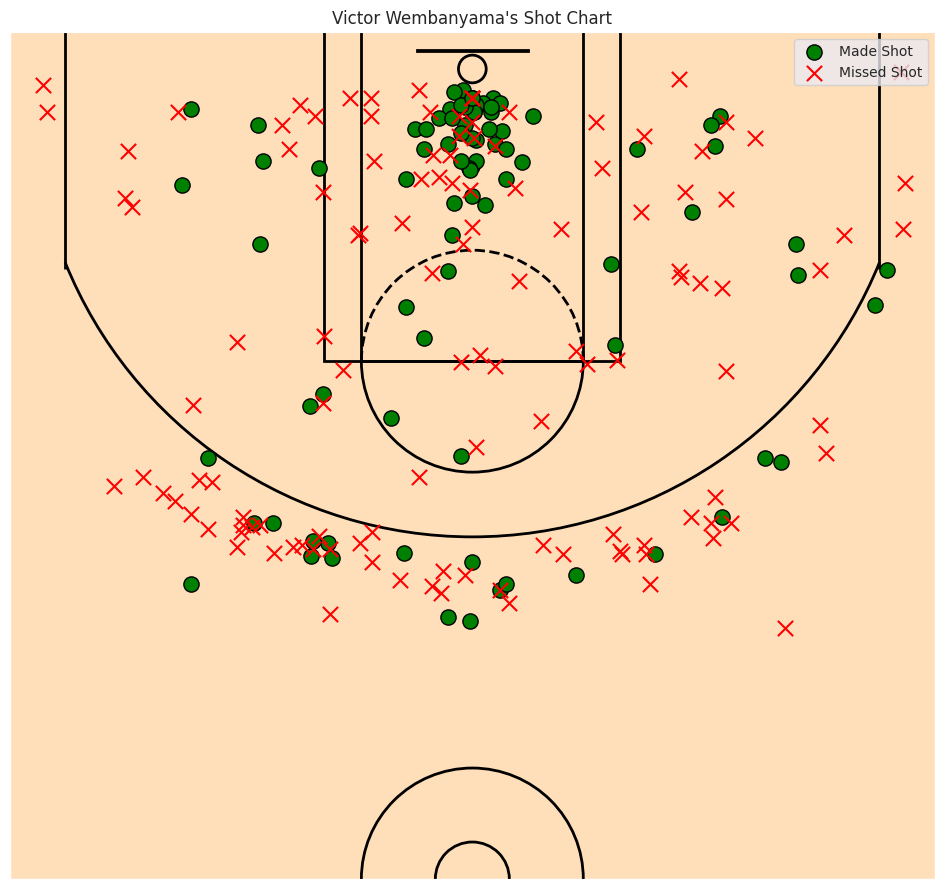

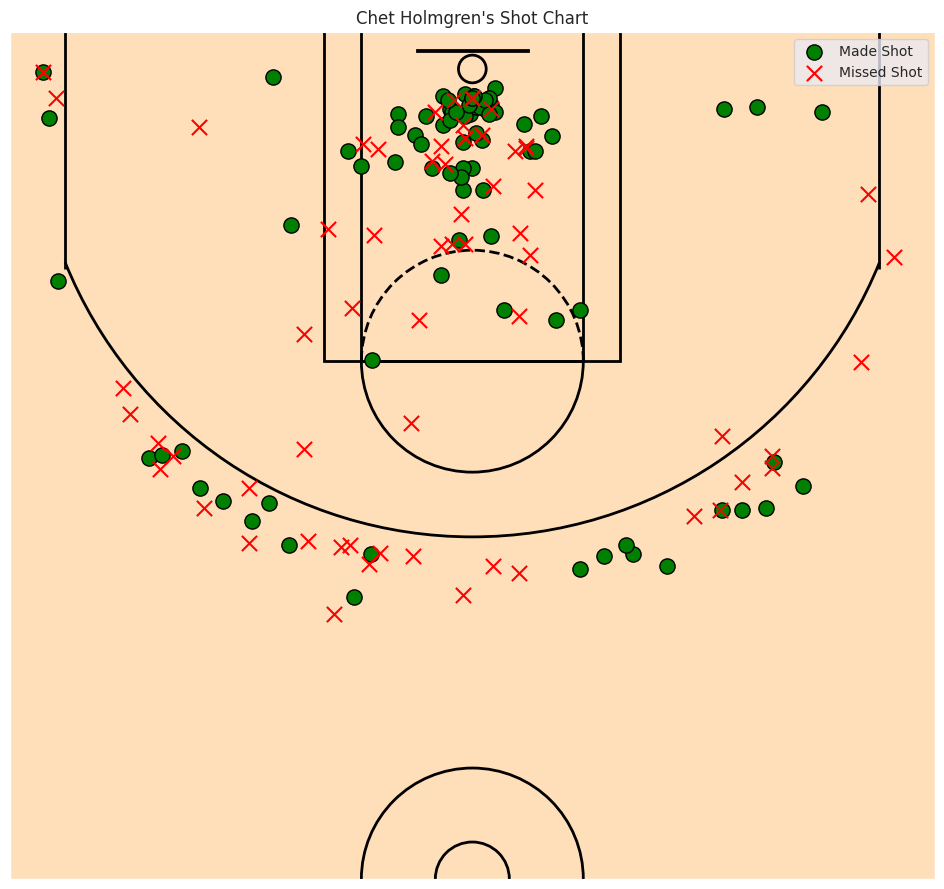

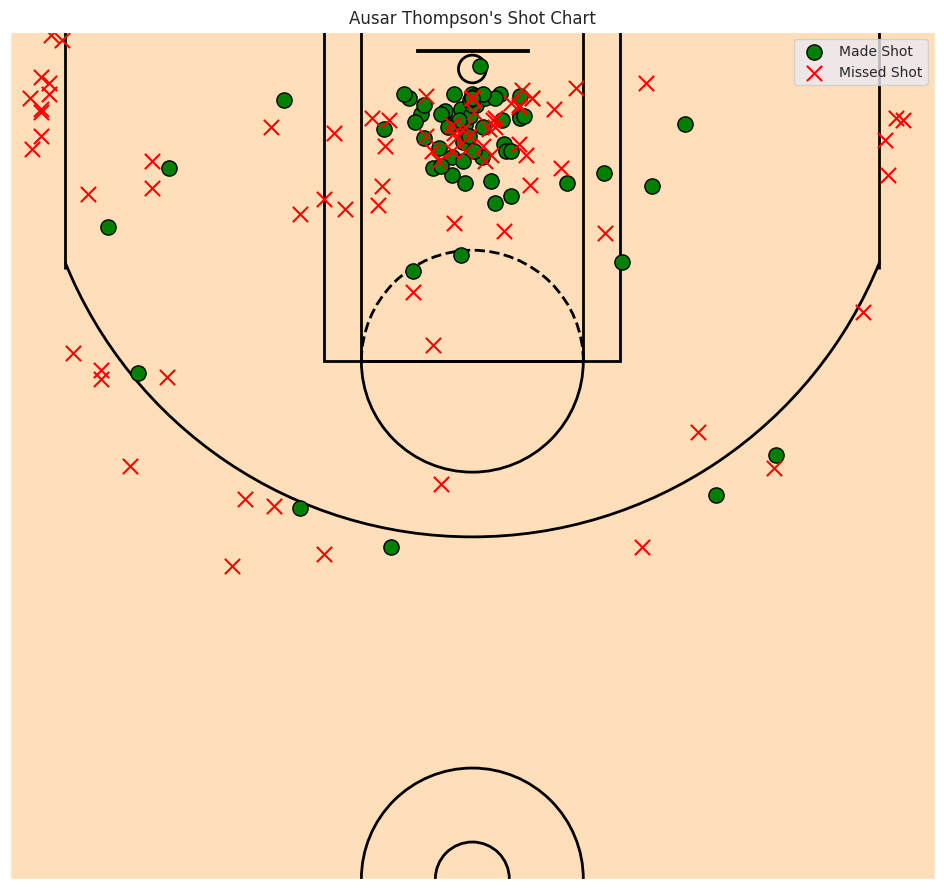

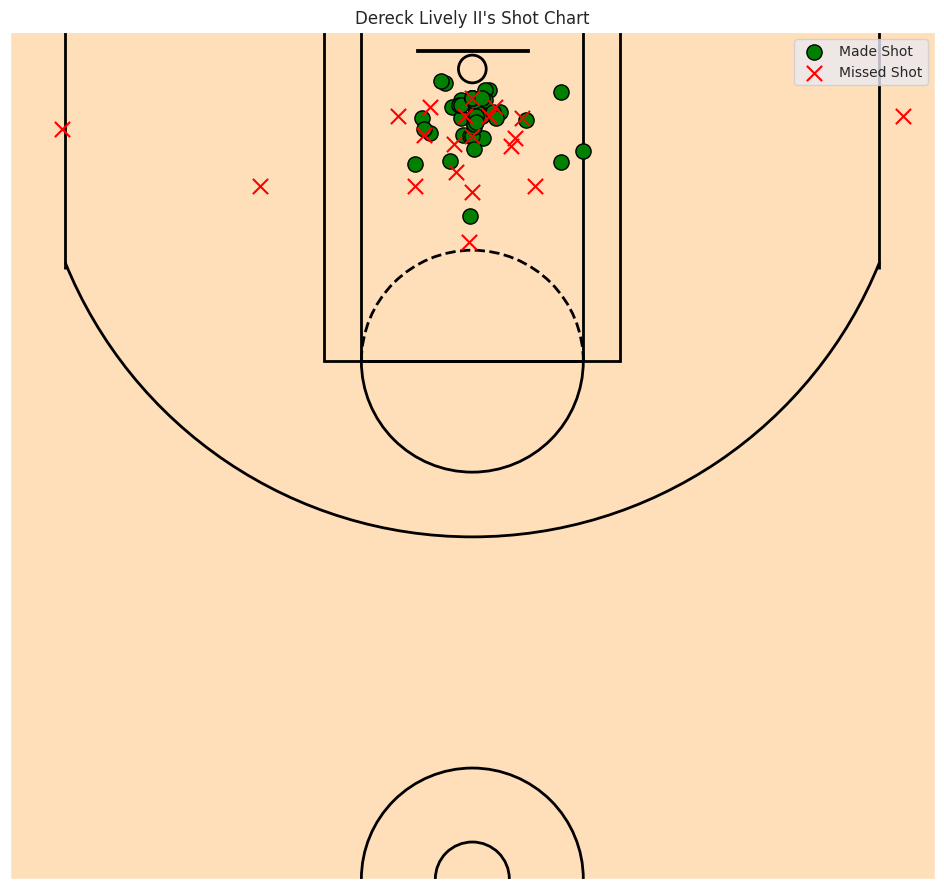

In [228]:
# @title
for player_name, shot_data in player_shot_data.items():
    fig, ax = plt.subplots(figsize=(12, 11))
    draw_court(ax)
    made_shots = shot_data[shot_data['SHOT_MADE_FLAG'] == 1]
    missed_shots = shot_data[shot_data['SHOT_MADE_FLAG'] == 0]
    ax.scatter(made_shots['LOC_X'], made_shots['LOC_Y'], marker='o', color='green', s=120, edgecolor= 'black', label='Made Shot')
    ax.scatter(missed_shots['LOC_X'], missed_shots['LOC_Y'], marker='x', color='red',s=120, label='Missed Shot')
    ax.set_title(f"{player_name}'s Shot Chart")
    ax.legend(loc='upper right')
    plt.show()

### Hexbin Shot Chart

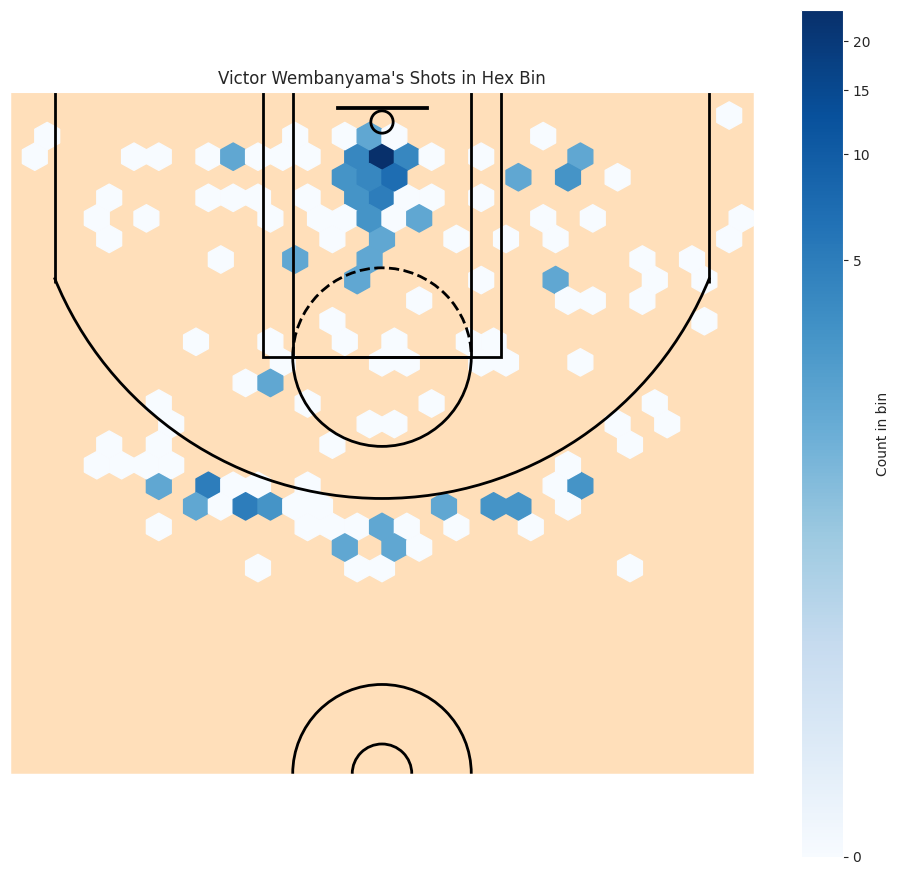

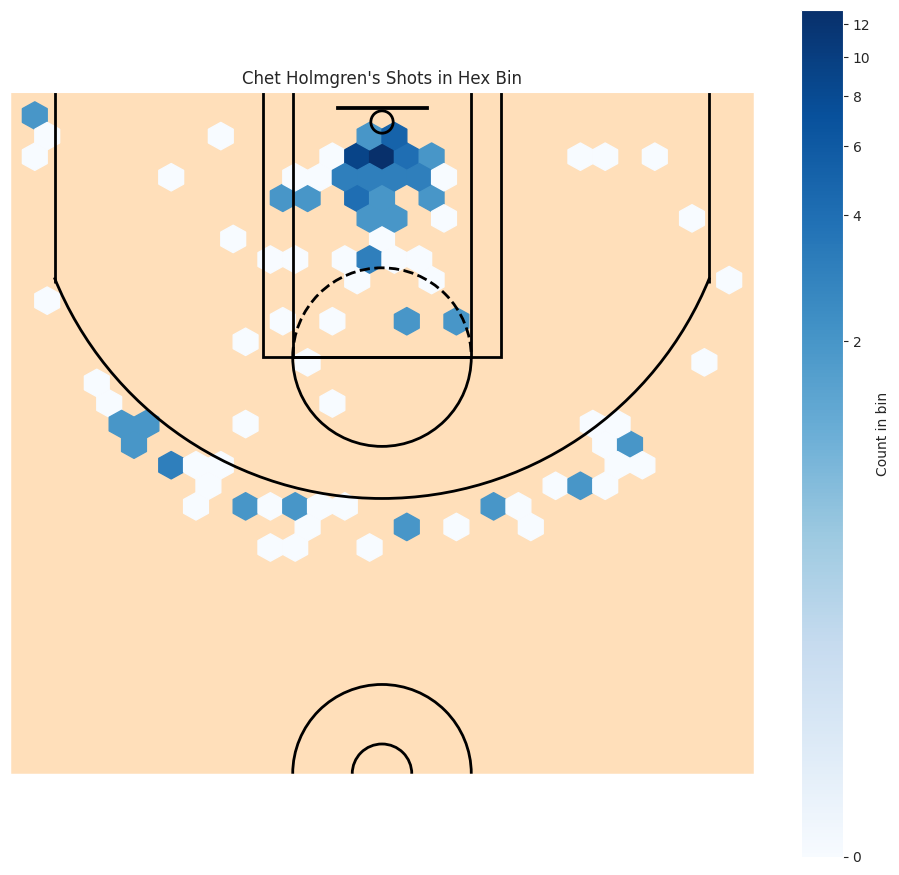

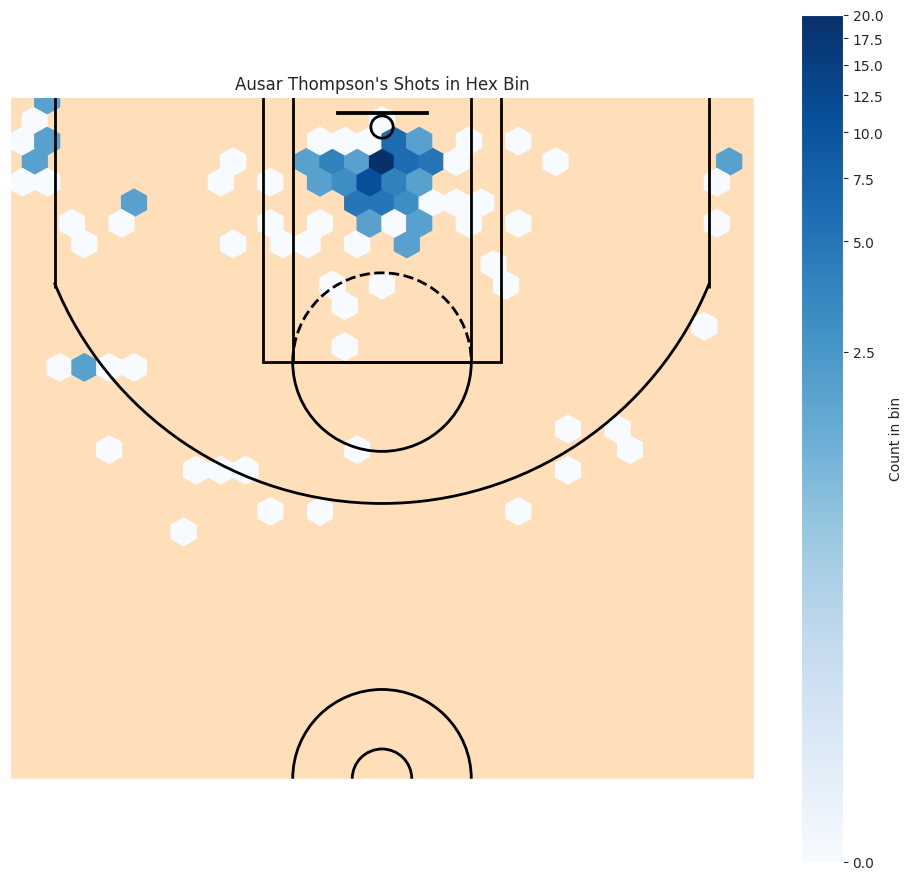

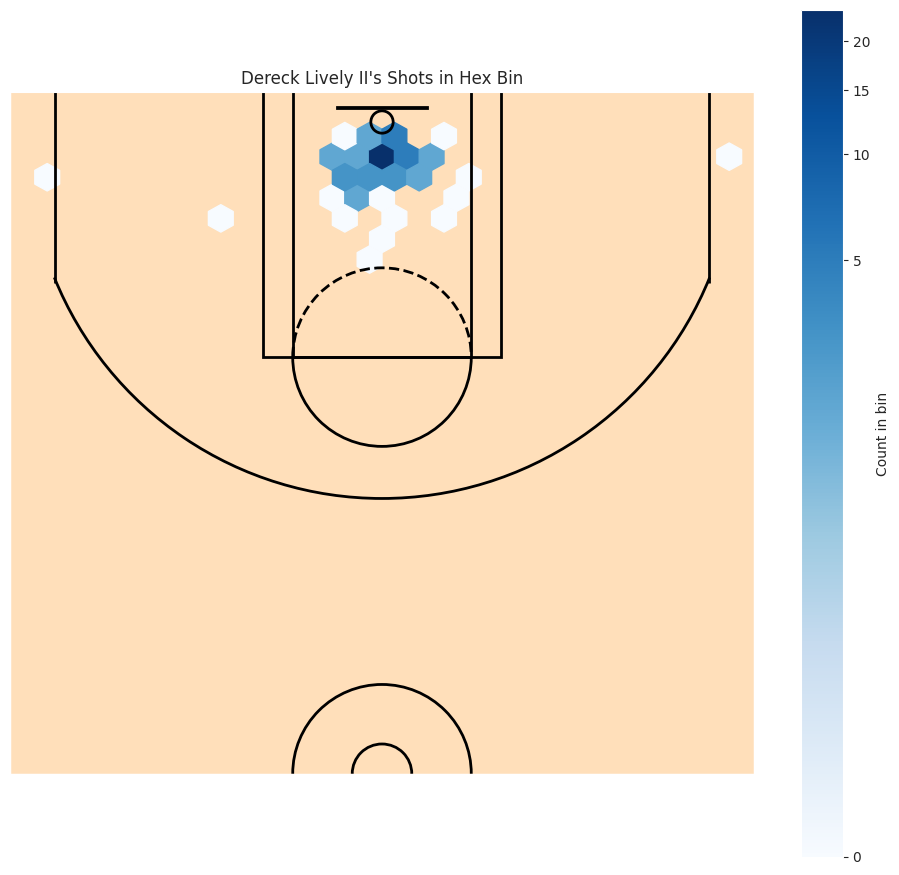

In [229]:
# @title
import matplotlib.colors as colors

for player_name, shot_data in player_shot_data.items():
    fig, ax = plt.subplots(figsize=(12, 11))
    draw_court(ax)

    # Create the hexbin plot
    hexbin = ax.hexbin(shot_data['LOC_X'], shot_data['LOC_Y'], gridsize=30, extent=(-250, 250, -47.5, 422.5), cmap='Blues', mincnt=1,
                      norm=colors.PowerNorm(gamma=0.2), zorder=0)

    # Add a color bar
    cbar = plt.colorbar(hexbin, ax=ax)
    cbar.set_label('Count in bin')

    ax.set_title(f"{player_name}'s Shots in Hex Bin")
    plt.show()

### As seen from the data the way each rookie shoots varies.

* Victor Wembanyama's shooting is varied (Midrange, Paint, 3-Points) but is most effective in the Paint. His 3-Point shots are mostly effective on the top of the key with a little bit on the wings.

* Chet Holmgren's shots are focused mostly on the paint and 3-pointers. His 3-pointers are shot mostly on the wings and he makes the shots with the highest percentage among the 4. He also has the best shooting percentage among the 4. If he keeps it up and improves his Free Throw Shooting, he could have a (50,40,90) Season.

* Ausar Thompson's shots are mostly from inside the paint with a little bit of midrange and outiside shooting.

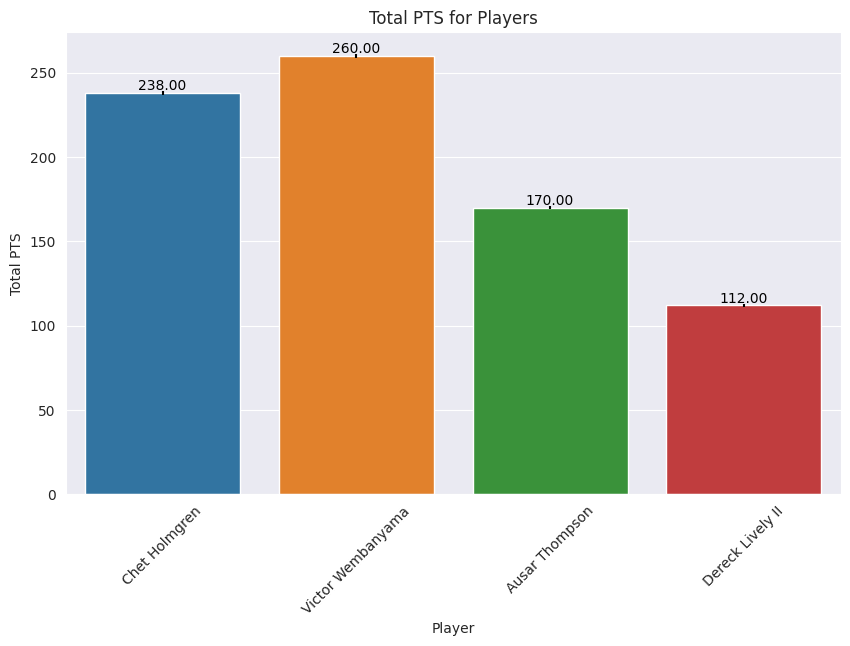

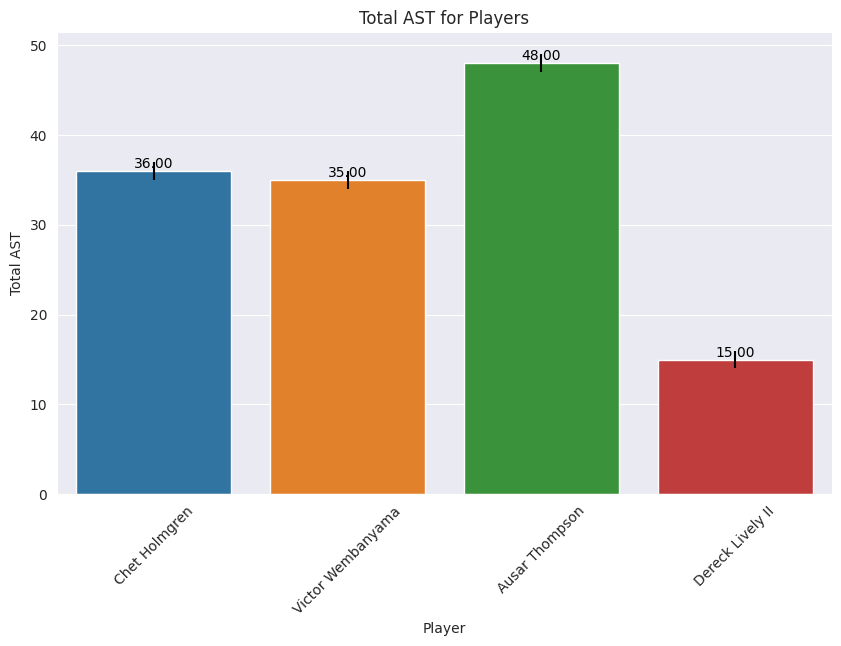

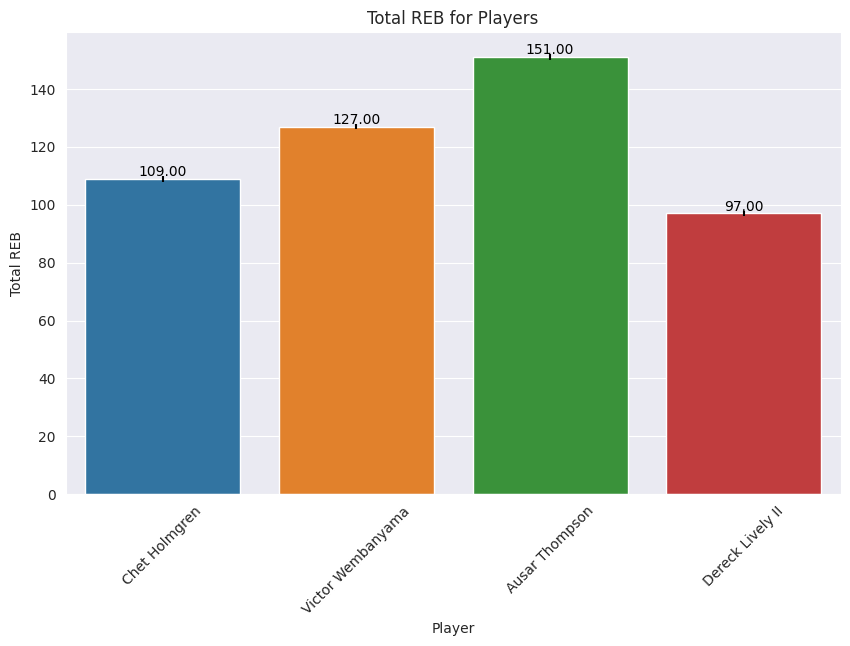

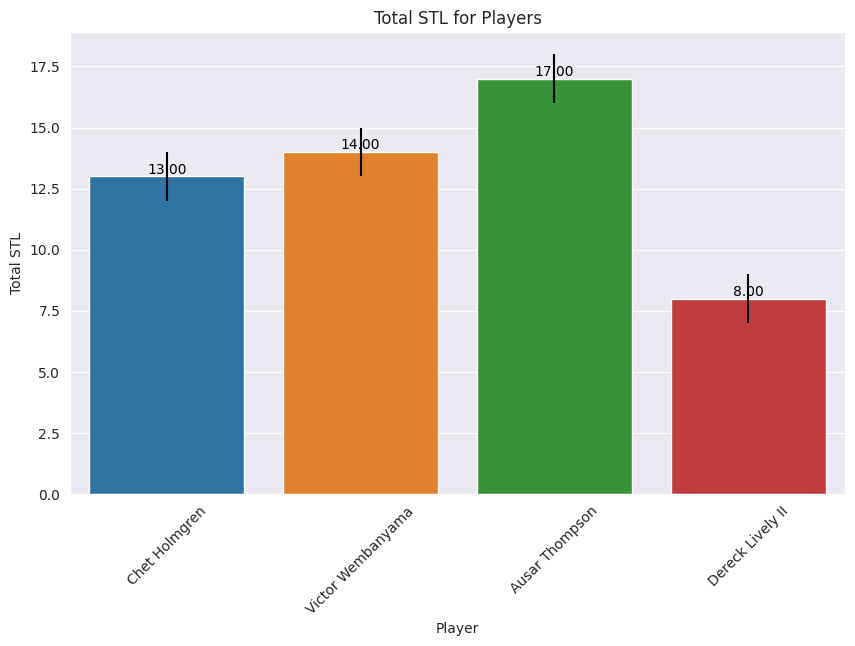

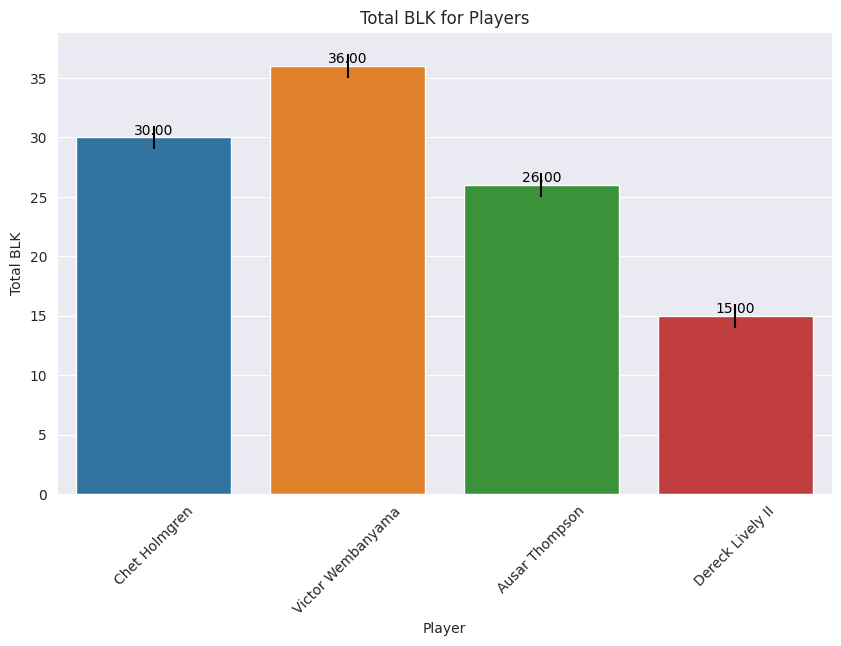

In [230]:
# @title
sns.set_style("darkgrid")

columns = ['PTS','AST','REB','STL','BLK']
for col in columns:
    # Plot for Total Metrics
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=combined_total, x='Player', y=col, yerr=True)
    plt.title(f'Total {col} for Players')
    plt.xticks(rotation=45)
    plt.ylabel(f'Total {col}')
    # Annotate each bar with its value

    for i, player in enumerate(combined_total.itertuples()):
        # Annotate bars
        p = ax.patches[i]
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

This graphs show the total metrics for the 4 players.

* Points - Victor Wembanyama has the highest points for the 4 of them.

* Assists, Rebounds and Steals - Ausar Thompson has the highest assist and rebound totals for the 4 of them.

* Blocks - The two 7-footers have the highest block totals from the 4 with Victor Wembanyama getting the top spot.

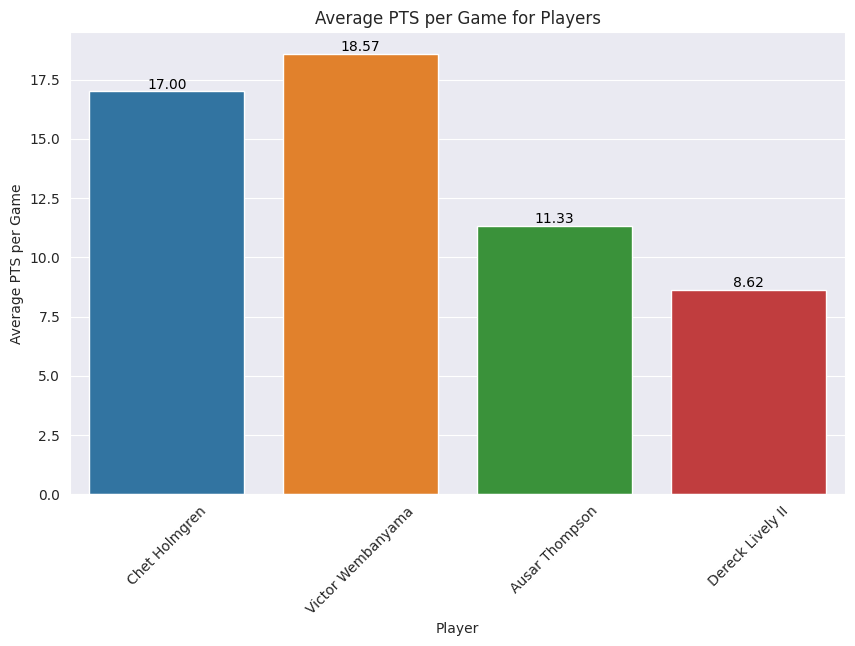

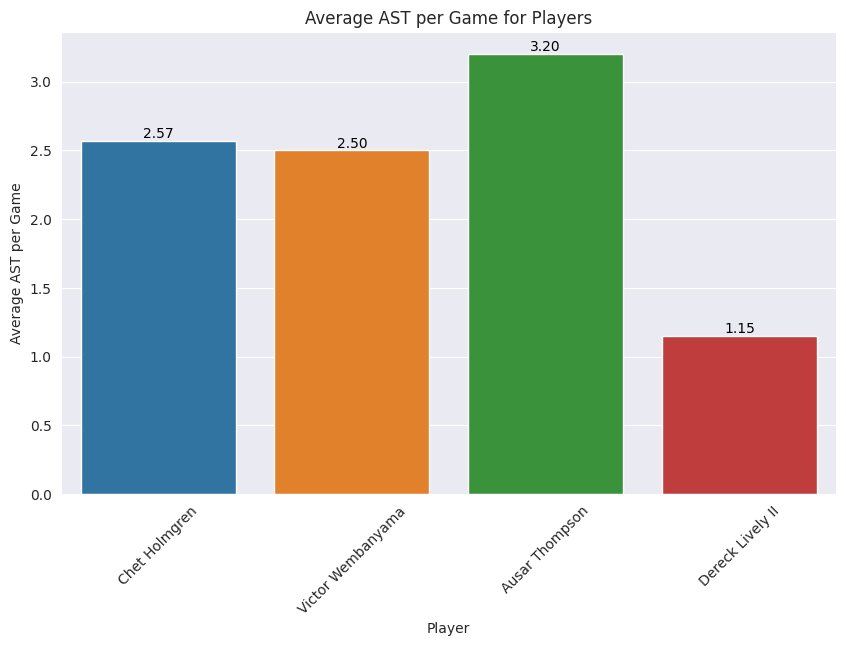

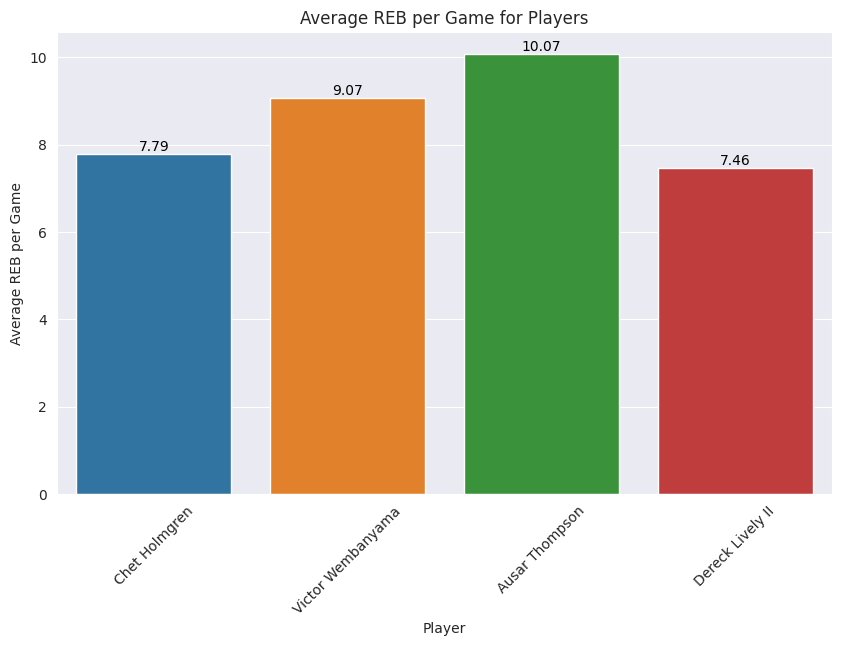

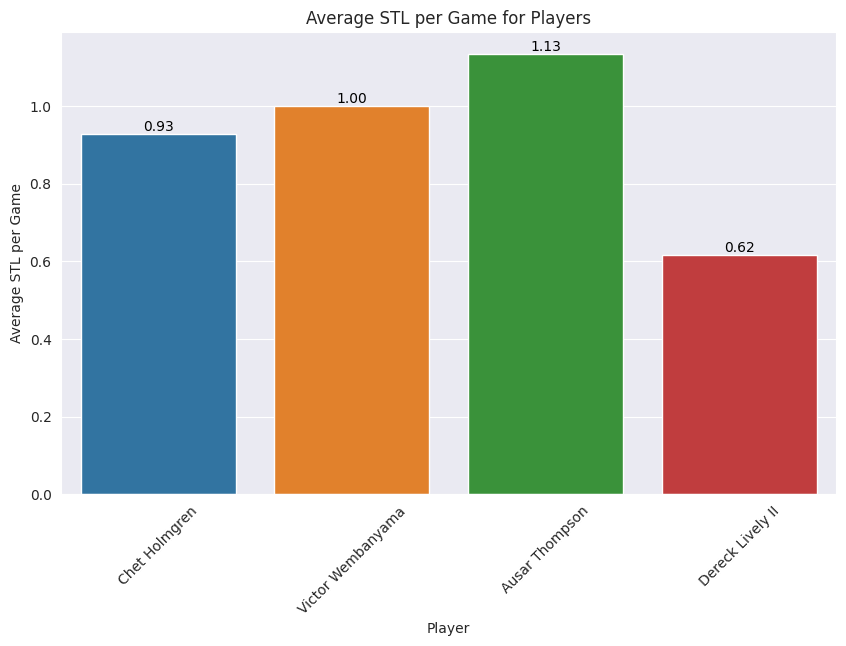

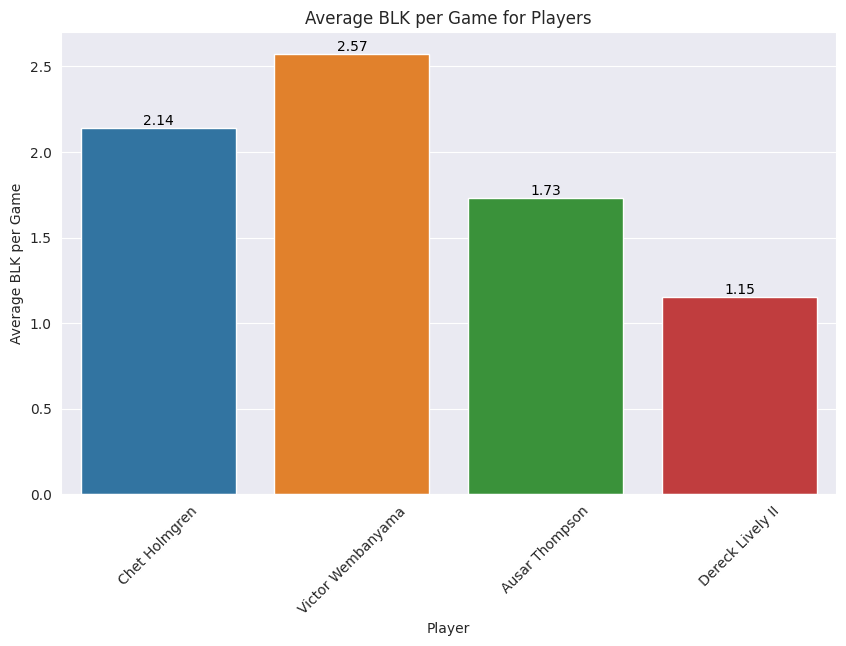

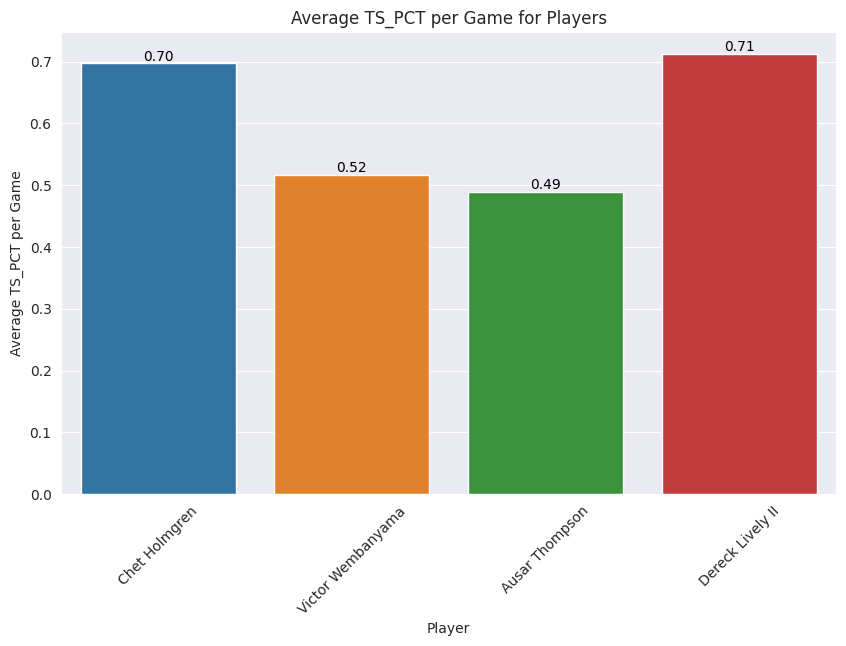

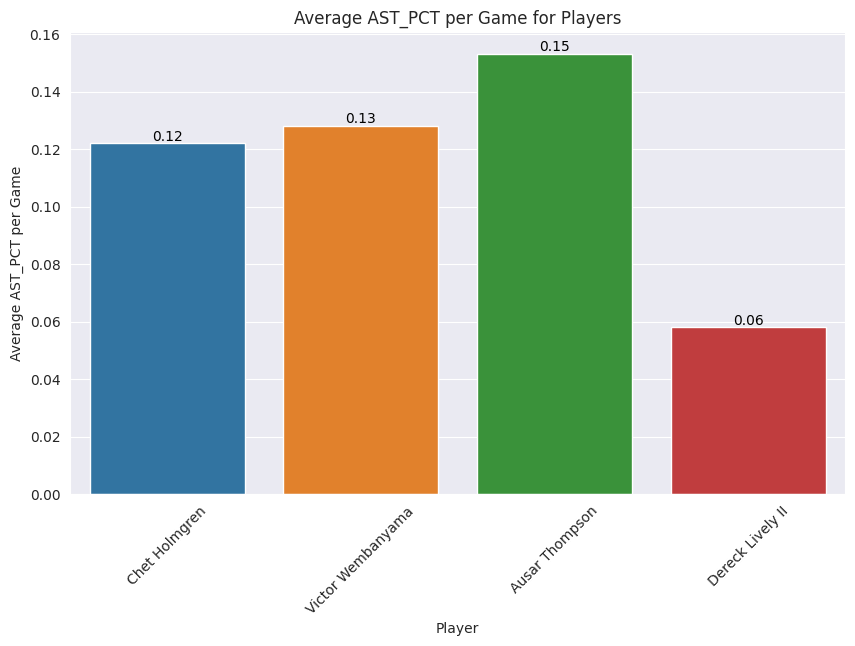

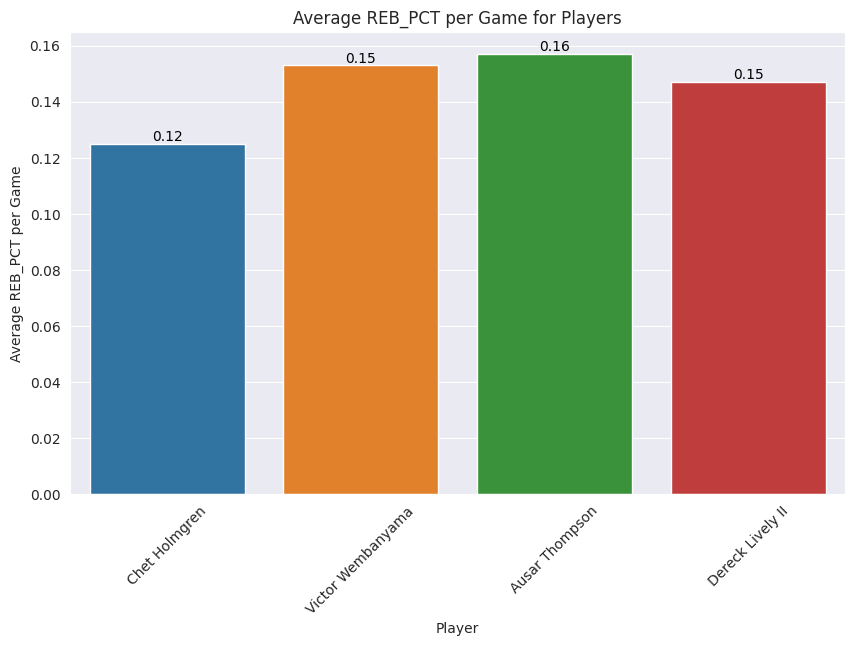

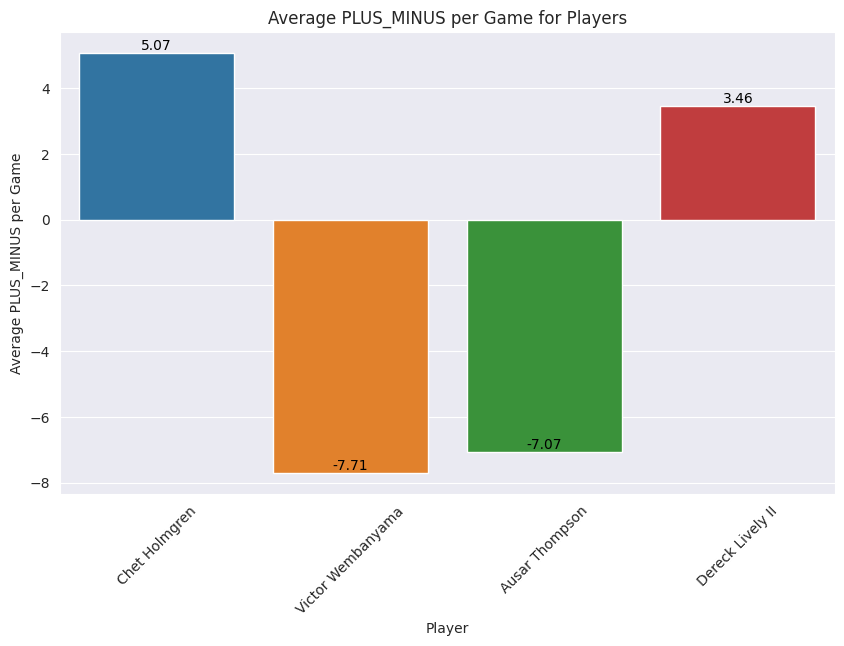

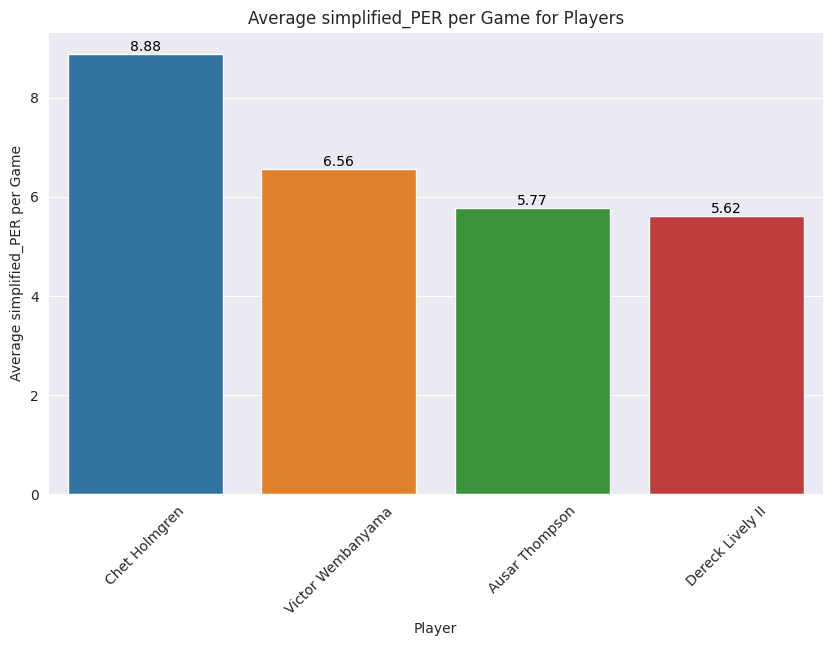

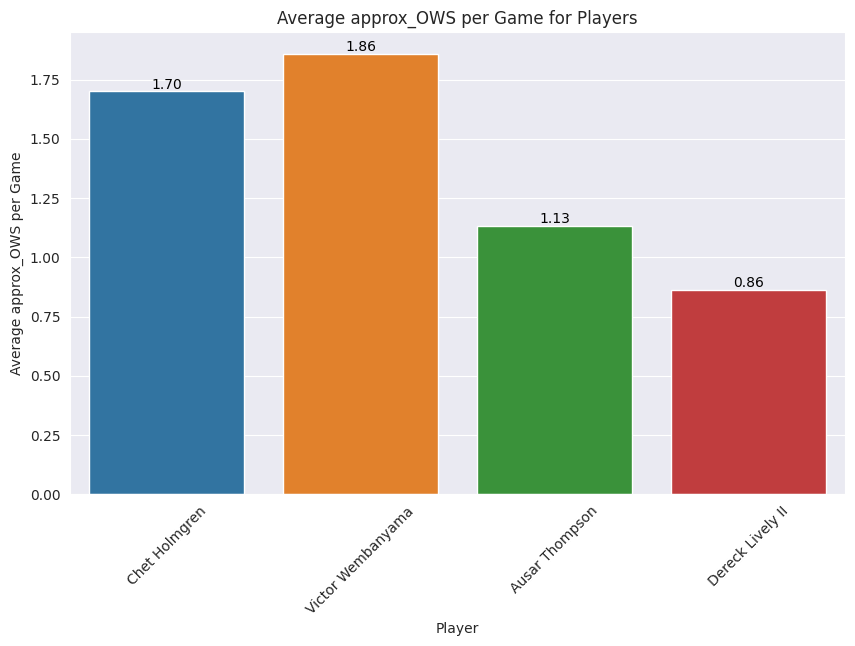

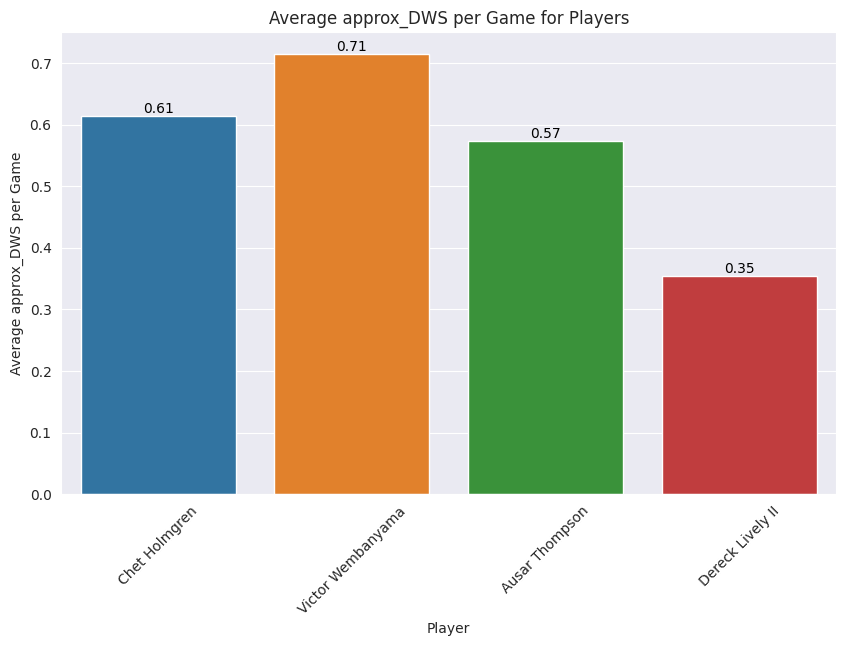

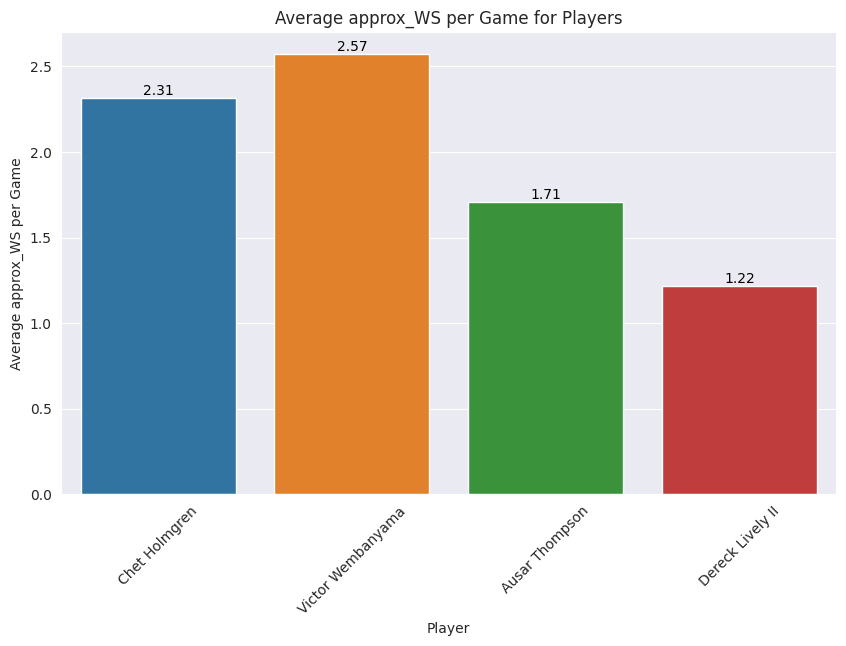

In [231]:
# @title
columns = ['PTS','AST','REB','STL','BLK', 'TS_PCT', 'AST_PCT','REB_PCT',
'PLUS_MINUS','simplified_PER','approx_OWS','approx_DWS','approx_WS']

for col in columns:
        # Plot for Average Metrics
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=combined_pg, x='Player', y=col)
    plt.title(f'Average {col} per Game for Players')
    plt.xticks(rotation=45)
    plt.ylabel(f'Average {col} per Game')
    # Annotate each bar with its value
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

The Average basic stats per game also reflects the total stats of the rookies.

The Advanced metrics are also shown in the visualizations.

# Ranking the Rookies

I did a ranking last time for All NBA players for 2020-21 NBA Season. Now I will be ranking the Rookies based on their current performance for this season. Since I was not able to get some of the data and just approximated them, here is my reasoning for the weights for this analysis:

1. Scoring (PTS, 20%): Points are a direct measure of scoring and crucial for evaluating offensive contribution.

2. Shooting Efficiency (TS_PCT, 15%): A key indicator of scoring efficiency, capturing effectiveness in shooting.

3. Playmaking (AST, 10%; AST_PCT, 5%): Reflects a player's ability to create scoring opportunities for teammates. The percentage metric is also included to account for the rate of assists relative to opportunities.

4. Rebounding (REB, 10%; REB_PCT, 5%): Important for both offensive and defensive plays, capturing control of the ball.

5. Defense (STL, 5%; BLK, 5%): Steals and blocks directly impact the opponent’s offensive strategies.

6. Overall Impact (PLUS_MINUS, 10%): Reflects the player's impact on the team's performance while on the court.

7. Efficiency and Contribution (simplified_PER, 10%): A holistic view of a player's efficiency and overall contribution.

8. Win Contribution (approx_OWS, 5%; approx_DWS, 5%; approx_WS, 5%): Though approximate, these metrics give a sense of a player's contribution to winning games, both offensively and defensively.

In [232]:
# @title
weights = {
    'PTS': 0.20, 'TS_PCT': 0.15, 'AST': 0.10, 'AST_PCT': 0.05,
    'REB': 0.10, 'REB_PCT': 0.05, 'STL': 0.05, 'BLK': 0.05,
    'PLUS_MINUS': 0.10, 'simplified_PER': 0.10,
    'approx_OWS': 0.05, 'approx_DWS': 0.05, 'approx_WS': 0.05
}

In [238]:
# @title
std_col = ['PTS', 'TS_PCT', 'AST', 'AST_PCT', 'REB', 'REB_PCT', 'STL', 'BLK',
           'PLUS_MINUS', 'simplified_PER', 'approx_OWS', 'approx_DWS', 'approx_WS']

scaler = StandardScaler()

combined_pg_std = scaler.fit_transform(combined_pg[std_col])

combined_pg[std_col] = combined_pg_std


In [239]:
# @title
for metric, weight in weights.items():
    combined_pg[metric + '_weighted'] = combined_pg[metric] * weight

# Sum up the weighted scores
combined_pg['weighted_score'] = combined_pg[[metric + '_weighted' for metric in weights]].sum(axis=1)

# Rank the players based on the weighted score
combined_pg['rank'] = combined_pg['weighted_score'].rank(ascending=False)

rank = combined_pg[['Player', 'weighted_score', 'rank']].sort_values(by='rank').head()

In [240]:
# @title
rank['Image_URL'] = data
rank

,Player,weighted_score,rank,Image_URL
0,Chet Holmgren,0.566521,1.0,https://cdn.nba.com/headshots/nba/latest/1040x...
1,Victor Wembanyama,0.358622,2.0,https://cdn.nba.com/headshots/nba/latest/1040x...
2,Ausar Thompson,-0.116915,3.0,https://cdn.nba.com/headshots/nba/latest/1040x...
3,Dereck Lively II,-0.808229,4.0,https://cdn.nba.com/headshots/nba/latest/1040x...


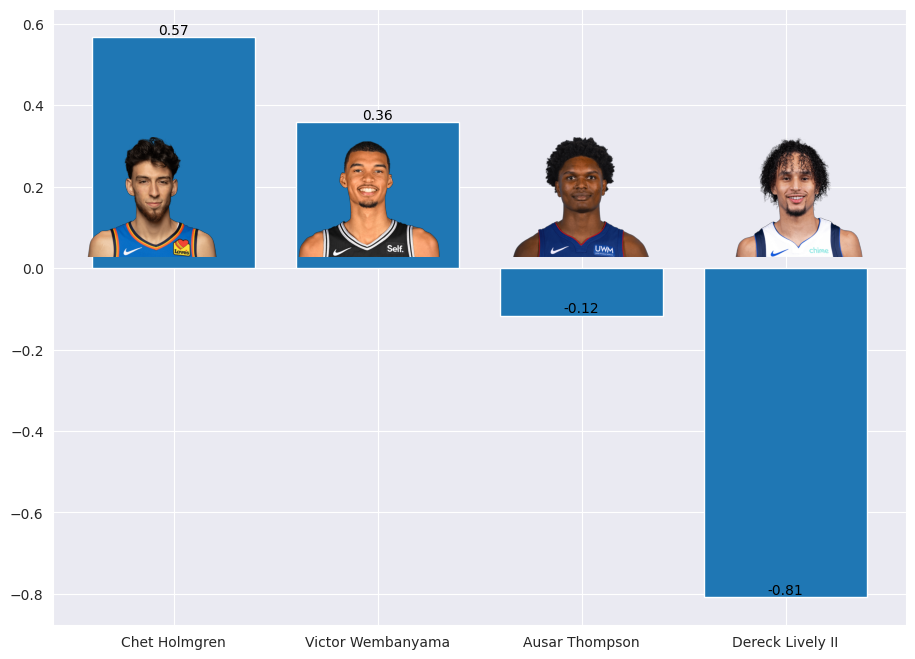

In [241]:
# @title
# Plotting
fig, ax = plt.subplots(figsize=(11,8))

# Plot standardized points (or any other statistic)
ax.bar(rank['Player'], rank['weighted_score'])

# Add player images
for i, player in enumerate(rank.itertuples()):
    image_url = player.Image_URL
    if isinstance(image_url, str):
        with urlopen(image_url) as url:
            img = mpimg.imread(url, format='jpeg')
            ax_image = fig.add_axes([0.13*1.5*i, 0.57, 0.43, 0.15])
            ax_image.imshow(img)
            ax_image.axis('off')  # Turn off axis

for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.show()

## The final table and Graph shows how the 4 players were ranked based on their weighted scores. It shows that as of now, Chet Holmgren is leading the race based on their statistics. However, the season has just started and we still have a long way to go and tell who really will be the ROTY of this season. As for me, I don't have a clear bet on who will win this season. I will just enjoy the ride and do some analysis on it maybe after every month, All-Star Weekend, and the end of the season and Let's see if the ranking will reflect what will the true results.

### I had some challenges adding the picture to the graph. I still need to improve how to do it later on. I will try to save the code and adjust it to be more dynamic so that I can save it as a boilerplate code later on.